# Standard Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [2]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA' #add proj name and dataset

In [3]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp


# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [4]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)
df = df_raw.copy()
#df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.205102,-0.307094,-1.194541,-0.474351,-0.705212,-0.093944,-0.554724,0.785728,...,-0.380979,-0.773997,-0.693878,-1.450006,-0.612203,-1.013031,0.706098,-0.435712,0,0
1,10/14/2023,936,-1.108022,-1.827942,-0.955605,-0.772672,0.808002,-0.579551,-0.109231,0.111436,...,-0.395107,-0.783669,-0.566780,-1.284105,-0.663551,-1.013031,0.622132,0.506578,0,0
2,10/15/2023,787,-1.593424,-2.045206,-1.855596,-1.496538,-1.079448,-1.391312,0.510846,-1.068574,...,-0.467866,-1.784458,-0.687852,-1.478292,-1.195888,-1.013031,0.586147,-1.075122,0,0
3,10/16/2023,1030,-1.156562,-1.502046,-0.999979,-0.698092,-0.916737,-0.572303,-1.560092,-0.731428,...,-0.396858,-0.842286,0.757340,-0.777197,-0.168277,0.603343,0.686106,-1.277042,0,0
4,10/17/2023,950,-1.302183,-1.393414,-1.002255,-1.470215,-0.664534,-0.825978,-1.385507,-0.267853,...,0.157420,-0.450040,0.104867,-1.071958,-0.427817,-0.819067,0.098345,-1.277042,0,0


In [5]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_0',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_06',
       'C_DIV_BUY_SSl21_0p0_0d0_12', 'C_DIV_CONN_DATAl21_0p0_0d0_12',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_0', 'C_DIV_GETNOW_ESSl21_0p0_0d0_12',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_06', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_12', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_06', 'C_PP_PKG_PREMl21_0p0_0d0_0',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_06',
       'C_PP_PKG_SSl21_0p0_0d0_06', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0', 'DIV_GMOC_SHOP_SSl21_0p0_0d0_0',
       'DIV_PKG_CONN_SERVICESl21_0p0_0d0_0',
       'DIV_PKG_HDStreamingl21_0p0_0d0_12', 'DIV_PKG_SS_CRASHl21_0p0_0d0_12',
       'DIV_PLANPAGE_ESSl21_0p0_0d0_06', 'DIV_PLANPAGE_HOMEl21_0p0_

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                212 non-null    object 
 1   A_OC_GOOGLE_SHOPPING                212 non-null    int64  
 2   C_DIV_BUY_CONNECTEDl21_0p0_0d0_0    212 non-null    float64
 3   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0   212 non-null    float64
 4   C_DIV_BUY_PREMIUMl21_0p0_0d0_06     212 non-null    float64
 5   C_DIV_BUY_SSl21_0p0_0d0_12          212 non-null    float64
 6   C_DIV_CONN_DATAl21_0p0_0d0_12       212 non-null    float64
 7   C_DIV_CONN_REMOTEl21_0p0_0d0_12     212 non-null    float64
 8   C_DIV_CONN_TRYl21_0p0_0d0_06        212 non-null    float64
 9   C_DIV_GETNOW_CONNl21_0p0_0d0_0      212 non-null    float64
 10  C_DIV_GETNOW_ESSl21_0p0_0d0_12      212 non-null    float64
 11  C_DIV_GETNOW_PREMl21_0p0_0d0_06     212 non-n

Flag variables will be unique to each use case. Be sure to include the most accurate control variables and flags that represent the most relevant adjustments to your data.

In [7]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.205102,-0.307094,-1.194541,-0.474351,-0.705212,-0.093944,-0.554724,0.785728,...,-0.380979,-0.773997,-0.693878,-1.450006,-0.612203,-1.013031,0.706098,-0.435712,0,0
1,10/14/2023,936,-1.108022,-1.827942,-0.955605,-0.772672,0.808002,-0.579551,-0.109231,0.111436,...,-0.395107,-0.783669,-0.566780,-1.284105,-0.663551,-1.013031,0.622132,0.506578,0,0
2,10/15/2023,787,-1.593424,-2.045206,-1.855596,-1.496538,-1.079448,-1.391312,0.510846,-1.068574,...,-0.467866,-1.784458,-0.687852,-1.478292,-1.195888,-1.013031,0.586147,-1.075122,0,0
3,10/16/2023,1030,-1.156562,-1.502046,-0.999979,-0.698092,-0.916737,-0.572303,-1.560092,-0.731428,...,-0.396858,-0.842286,0.757340,-0.777197,-0.168277,0.603343,0.686106,-1.277042,0,0
4,10/17/2023,950,-1.302183,-1.393414,-1.002255,-1.470215,-0.664534,-0.825978,-1.385507,-0.267853,...,0.157420,-0.450040,0.104867,-1.071958,-0.427817,-0.819067,0.098345,-1.277042,0,0


Set KPI and date columns

In [8]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}

In [9]:
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery
# REATE OR REPLACE MODEL `test.model`  #update project name
# OPTIONS (model_type='linear_reg',
#         data_split_method = 'SEQ', #use these options for train/test splits
#         data_split_eval_fraction = 0.1,
#         data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM df
#     ORDER BY date; #update project name

In [10]:

# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the fraction for the test set
test_fraction = 0.05

# Compute the index at which to split the data
split_index = int((1 - test_fraction) * len(df))

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Define the features (X) and target (y)
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create and fit the model
model_train = LinearRegression()
model_train.fit(X_train, y_train)



LinearRegression()

In [11]:
# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the features (X) and target (y)
X_all = df.drop([kpi_col, date_col], axis=1)
y_all = df[kpi_col]

# Create and fit the model
model_all = LinearRegression()
model_all.fit(X_all, y_all)


LinearRegression()

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns the following error metrics: mean absolute error, mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [12]:
# Predict using the model
y_test_pred = model_train.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
median_ae = median_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
explained_variance = explained_variance_score(y_test, y_test_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,71.156728,7843.689514,58.524471,0.029268,0.609972


In [13]:
# Predict using the model
y_pred = model_all.predict(X_all)

# Calculate evaluation metrics
mse = mean_squared_error(y_all, y_pred)
mae = mean_absolute_error(y_all, y_pred)
median_ae = median_absolute_error(y_all, y_pred)
r2 = r2_score(y_all, y_pred)
explained_variance = explained_variance_score(y_all, y_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,102.641255,17846.648823,82.664981,0.938908,0.938908


In [14]:
import statsmodels.api as sm

# Assuming X_all is your features and y_all is the target variable
X_all = sm.add_constant(X_all)  # Adding a constant to the model
model = sm.OLS(y_all, X_all).fit()  # Fit the model

# Get the summary
model_summary = model.summary()
print(model_summary)


                             OLS Regression Results                             
Dep. Variable:     A_OC_GOOGLE_SHOPPING   R-squared:                       0.939
Model:                              OLS   Adj. R-squared:                  0.927
Method:                   Least Squares   F-statistic:                     80.01
Date:                  Tue, 09 Jul 2024   Prob (F-statistic):           3.86e-90
Time:                          15:04:20   Log-Likelihood:                -1338.5
No. Observations:                   212   AIC:                             2747.
Df Residuals:                       177   BIC:                             2864.
Df Model:                            34                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [ ]:
# results = pd.DataFrame()
# results['actual'] = df[kpi_col]
# results['predicted'] = model_predictions.predicted_y1

In [15]:
# Predict
predicted_y = model_all.predict(df.drop([kpi_col, date_col], axis=1))

# Create a DataFrame for results
results = pd.DataFrame()
results['actual'] = df[kpi_col]  # Replace kpi_col with your actual KPI column name
results['predicted'] = predicted_y

In [16]:
# Assuming you have a DataFrame 'test_df' with features and actual values, and 'model' is your trained model


# Create the model_predictions DataFrame
model_predictions = df[[kpi_col]].copy()  # Actual values
model_predictions['predicted_y1'] = predicted_y

# Calculate residuals
model_predictions['residuals'] = model_predictions['predicted_y1'] - model_predictions[kpi_col]
#model_predictions.head()

In [17]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital tactic on conversions

### 3.1) Relative Importance

Use the [relativeImp](https://pypi.org/project/relativeImp/) package to conduct key driver analysis and generate relative importance values by feature in the model.


The relativeImp function produces a raw relative importance and a normalized relative importance value.

- Raw relative importance sums to the r-squared of the linear model.
- Normalized relative importance is scaled to sum to 1

In [18]:
conversions = kpi_col
df = df.drop(columns = date_col)
tactics = df[df.columns[df.columns != conversions]].columns.to_list()
relative_importance_results = relativeImp(df,
                                          outcomeName = conversions,
                                          driverNames = tactics)

In [19]:
relative_importance_results.sort_values(by = 'rawRelaImpt', ascending = False)

,driver,rawRelaImpt,normRelaImpt
18,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,0.284764,30.329308
24,DIV_PLANPAGE_ESSl21_0p0_0d0_06,0.127558,13.585732
32,Is_Holiday,0.069515,7.403858
15,C_PP_PKG_REMOTEl21_0p0_0d0_0,0.041366,4.405806
19,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,0.034599,3.684989
22,DIV_PKG_HDStreamingl21_0p0_0d0_12,0.033889,3.609406
30,SC_HOMEPAGEl21_0p0_0d0_12,0.031094,3.311683
14,C_PP_PKG_PREMl21_0p0_0d0_0,0.029075,3.096699
13,C_PP_PKG_ESSl21_0p0_0d0_06,0.027473,2.926100
23,DIV_PKG_SS_CRASHl21_0p0_0d0_12,0.026952,2.870561


In [23]:
round(relative_importance_results.rawRelaImpt.sum(),2) #Model's R-squared
#round(relative_importance_results.normRelaImpt.sum(),2) #Model's R-squared


0.94

## 4) Validate Linear Regression Model Assumptions

For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:

  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity
  - Absence of autocorrelation of residuals



If any of the model assumptions fail, a different model specification, as well as re-examination of the data should be considered

Incorrect model use can lead to unreliable results

### 4.1) Generate residuals

Calculate model residuals as the difference from predicted y1 values and actual y1 values


In [24]:
model_predictions['residuals'] = model_predictions.predicted_y1 - model_predictions[kpi_col]

### 4.2) Linearity

Visually inspect linearity between target variable (y1) and predictions

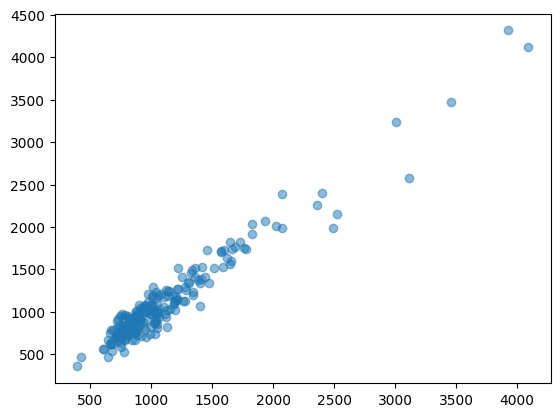

In [25]:
plt.plot(model_predictions.predicted_y1,model_predictions[kpi_col],'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

Visually inspect the residuals to confirm normality

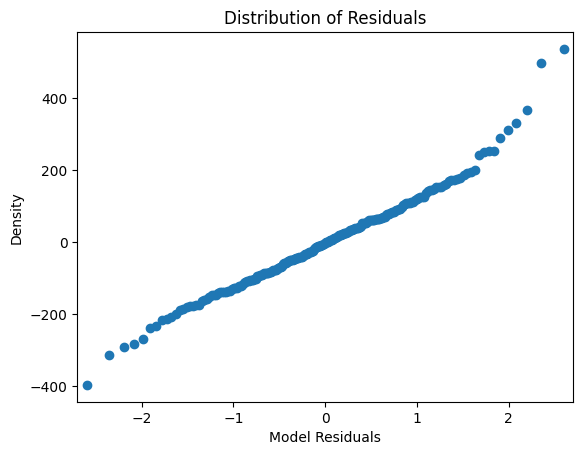

In [26]:
fig = sm.qqplot(model_predictions.residuals)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Homoscedasticity


Visually inspect residuals to confirm constant variance

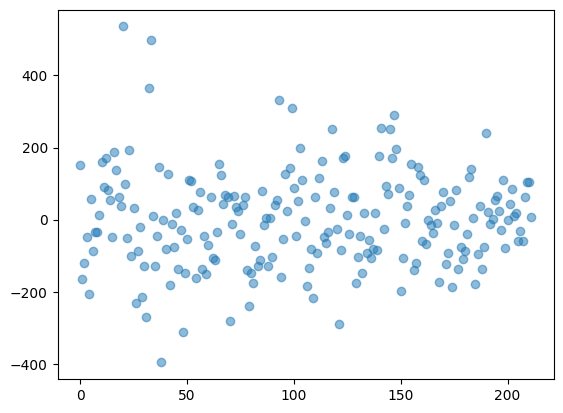

In [27]:
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

### 4.5) Absence of Autocorrelation of the residuals

The Durbin Watson test is a statistical test for detecting autocorrelation of the model residuals

In [28]:
dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',round(dw,1))

Durbin-Watson 1.8


In [29]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming 'df' is your DataFrame with all the predictor variables
X = df.drop('A_OC_GOOGLE_SHOPPING', axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                               feature       VIF
0                                const  1.146926
1     C_DIV_BUY_CONNECTEDl21_0p0_0d0_0  6.269785
2    C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0  3.310056
3      C_DIV_BUY_PREMIUMl21_0p0_0d0_06  6.275167
4           C_DIV_BUY_SSl21_0p0_0d0_12  3.555037
5        C_DIV_CONN_DATAl21_0p0_0d0_12  1.840926
6      C_DIV_CONN_REMOTEl21_0p0_0d0_12  2.563439
7         C_DIV_CONN_TRYl21_0p0_0d0_06  1.442419
8       C_DIV_GETNOW_CONNl21_0p0_0d0_0  3.658483
9       C_DIV_GETNOW_ESSl21_0p0_0d0_12  1.593686
10     C_DIV_GETNOW_PREMl21_0p0_0d0_06  3.942930
11       C_DIV_GETNOW_SSl21_0p0_0d0_12  4.691398
12   C_PP_PKG_APP_ACCESSl21_0p0_0d0_12  1.930919
13    C_PP_PKG_CONNECTEDl21_0p0_0d0_12  5.619746
14          C_PP_PKG_ESSl21_0p0_0d0_06  4.223633
15          C_PP_PKG_PREMl21_0p0_0d0_0  4.751510
16        C_PP_PKG_REMOTEl21_0p0_0d0_0  9.502010
17           C_PP_PKG_SCl21_0p0_0d0_06  1.481955
18           C_PP_PKG_SSl21_0p0_0d0_06  2.816611
19      DIV_GMOC_SHO

## 5) Export Final Results

In [31]:
final_results_df = relative_importance_results[['driver','rawRelaImpt','normRelaImpt']]
final_results_df.to_csv('rba_final_output_Std_Reg.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_Std_Reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>